In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random

import torch
import torch.nn as nn
from tqdm import tqdm

import torch.nn.functional as F

# import mnist from torchvision
from torchvision import datasets, transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



class SimpleCNN(nn.Module):
    def __init__(self, embedding_size=32):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)

        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, embedding_size) # the final emb size is 32

        self.embedding_size = embedding_size
    
    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 32*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x

# Contrastive loss

class ContrastiveLoss(nn.Module):
    
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive
    
# Triplet loss

class TripletLoss(nn.Module):

    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.sum(torch.pow(anchor - positive, 2), 1)
        distance_negative = torch.sum(torch.pow(anchor - negative, 2), 1)
        loss = torch.relu(distance_positive - distance_negative + self.margin) # relu è max(0, x)
        return torch.mean(loss)
    

class TripletDataset:
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.classes = list(set(mnist_dataset.targets.numpy()))
        self.class_to_images = {c: [] for c in self.classes}
        
        # Group images by class
        for i in range(len(mnist_dataset)):
            image, label = mnist_dataset[i]
            self.class_to_images[label].append(image)
        
    def __getitem__(self, index):
        anchor_image, anchor_label = self.mnist_dataset[index]
        
        # Select positive image from the same class
        positive_image = random.choice(self.class_to_images[anchor_label])
        
        # Select negative image from a different class
        negative_label = random.choice([c for c in self.classes if c != anchor_label])
        negative_image = random.choice(self.class_to_images[negative_label])
        
        return anchor_image, positive_image, negative_image
    
    
    def __len__(self):
        return len(self.mnist_dataset)
    

In [2]:
# creating and loading dataset
mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

triplet_dataset = TripletDataset(mnist)
triplet_loader = torch.utils.data.DataLoader(triplet_dataset, batch_size=1024, shuffle=True) # fissa la batch size come la vuoi tu


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:13<00:00, 758178.22it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 248732.97it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1057505.99it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4545580.71it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# test a forward pass and print shapes
model = SimpleCNN().to(device)

# taking a random sample from the dataset, we should get a tensor of shape [1, 32]
sample =  mnist[random.choice(range(len(mnist)))]
print(model(sample[0].unsqueeze(0).to(device)).shape)

torch.Size([1, 32])


torch.Size([1024, 1, 28, 28]) torch.Size([1024, 1, 28, 28]) torch.Size([1024, 1, 28, 28])


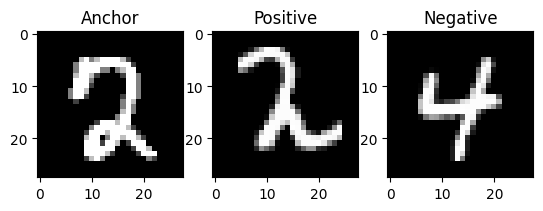

In [4]:
sample = next(iter(triplet_loader))
print(sample[0].shape, sample[1].shape, sample[2].shape)

# plot with matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(sample[0][0].squeeze(), cmap='gray')
axs[1].imshow(sample[1][0].squeeze(), cmap='gray')
axs[2].imshow(sample[2][0].squeeze(), cmap='gray')

# put legend 
axs[0].set_title('Anchor')
axs[1].set_title('Positive')
axs[2].set_title('Negative')

plt.show()

In [5]:
tripletmodel = SimpleCNN()
tripletloss = TripletLoss()


optimizer = torch.optim.Adam(tripletmodel.parameters(), lr=1e-3)

tripletmodel.to(device)


for epoch in range(10):
    pbar = tqdm(triplet_loader)
    epoch_loss = 0
    for anchor, positive, negative in pbar:

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()

        anchor_embedding = tripletmodel(anchor)
        positive_embedding = tripletmodel(positive)
        negative_embedding = tripletmodel(negative)
        
        loss = tripletloss(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_postfix_str(f'Loss {loss.item()}')
        
    print(f'Epoch {epoch}, Loss {epoch_loss/len(triplet_loader)}')


100%|██████████| 59/59 [00:09<00:00,  6.29it/s, Loss 0.07140970975160599]


Epoch 0, Loss 0.2887392492365029


100%|██████████| 59/59 [00:08<00:00,  7.05it/s, Loss 0.020807037129998207]


Epoch 1, Loss 0.05614815658684504


100%|██████████| 59/59 [00:08<00:00,  6.91it/s, Loss 0.03614825755357742] 


Epoch 2, Loss 0.03648939501431029


100%|██████████| 59/59 [00:08<00:00,  6.72it/s, Loss 0.025670412927865982]


Epoch 3, Loss 0.02947018983758102


100%|██████████| 59/59 [00:09<00:00,  6.17it/s, Loss 0.007459123153239489]


Epoch 4, Loss 0.023036619766725826


100%|██████████| 59/59 [00:09<00:00,  6.19it/s, Loss 0.014370867982506752]


Epoch 5, Loss 0.020350134331669847


100%|██████████| 59/59 [00:08<00:00,  6.61it/s, Loss 0.009722432121634483]


Epoch 6, Loss 0.01716321014593971


100%|██████████| 59/59 [00:09<00:00,  6.31it/s, Loss 0.024814026430249214]


Epoch 7, Loss 0.0165075505925816


100%|██████████| 59/59 [00:08<00:00,  6.72it/s, Loss 0.015747148543596268] 


Epoch 8, Loss 0.014416924164772539


100%|██████████| 59/59 [00:08<00:00,  7.11it/s, Loss 0.025233345106244087] 

Epoch 9, Loss 0.013739177057424844


In [6]:
tripletmodel.eval()
embeddings = []
labels = []

#take the first 1000 images
for i in range(1000):
    image, label = mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = tripletmodel(image)
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())

embeddings = np.concatenate(embeddings, axis=0)


# ogni colonna del dataframe è una dimensione dell'embedding (x0, x1, x2, ..., x31) e l'ultima colonna è la label
df = pd.DataFrame(embeddings, columns=[f'x{i}' for i in range(embeddings.shape[1])])
df['label'] = labels

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,label
0,0.226940,0.434133,-0.615751,-0.402404,0.514419,-0.148666,0.182258,0.039870,0.201491,-0.298442,...,0.163166,0.125136,-0.095391,0.003790,0.227055,0.217304,0.240281,0.059089,0.520184,5
1,-0.514927,-0.378700,0.210196,0.369228,-0.662723,0.167374,0.016240,0.044397,-0.216426,0.473679,...,-0.115515,-0.756720,0.387294,-0.021987,-0.859120,0.241186,0.228201,0.086807,-0.259351,0
2,-0.817178,-0.241809,0.211653,0.100187,0.134117,0.132358,0.005214,-0.659822,-0.244647,-0.552949,...,-0.080452,-0.378116,-0.339608,0.644645,-0.420593,-0.174391,0.312829,1.029513,-0.115739,4
3,-0.637997,-0.054918,0.071782,-0.121269,0.058808,-0.074377,0.226433,0.026020,0.136727,-0.571825,...,-0.137653,-0.028730,-0.172993,0.001008,-0.107944,0.177137,0.054022,0.156025,0.444239,1
4,-0.456106,0.124978,-0.174540,0.198265,0.653884,0.044203,0.076378,-0.414706,-0.043600,-0.388461,...,0.050573,-0.069581,0.107213,0.363669,-0.494797,0.375126,1.367445,0.610325,-0.208546,9


<Axes: xlabel='pca1', ylabel='pca2'>

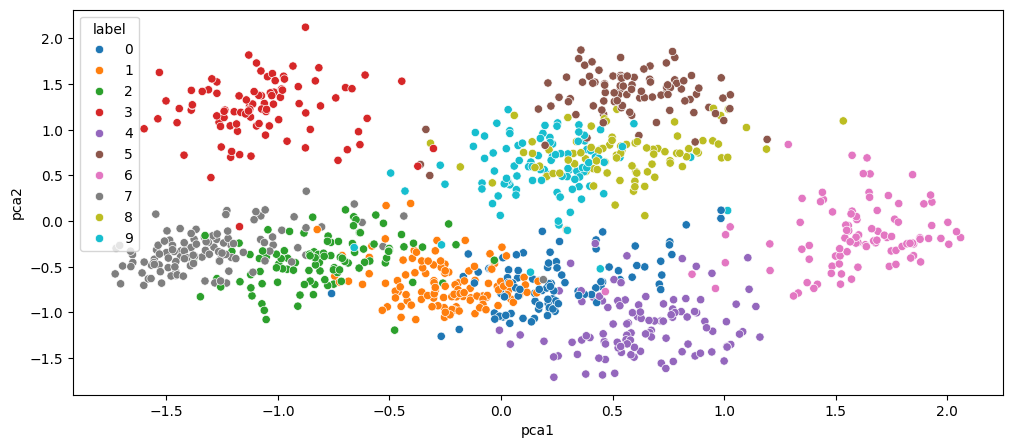

In [7]:
# make pca and plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

df['pca1'] = pca_embeddings[:, 0]
df['pca2'] = pca_embeddings[:, 1]


plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='label', palette='tab10')

### Funziona :)



## Evaluating goodness of clustering

Triplet Score: 0.563612699508667


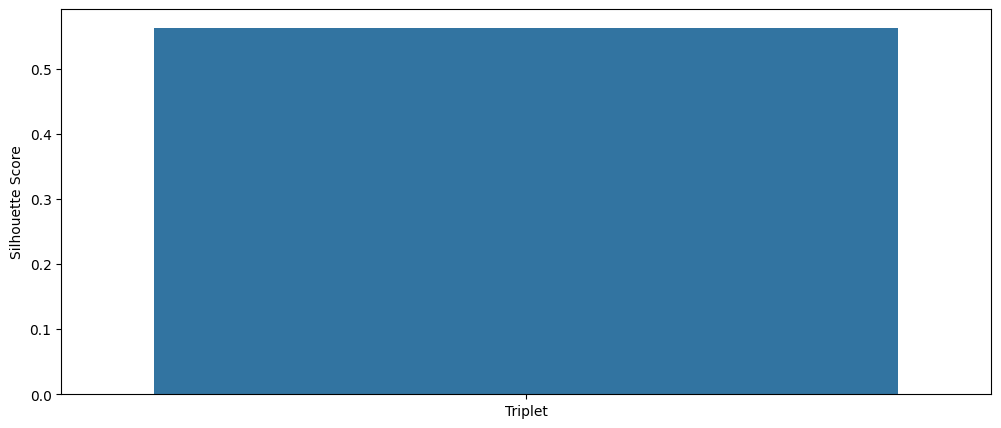

In [9]:
# We can use a data mining approach like silhouette score to evaluate the quality of the clustering
# So we can compare different Losses: TripletLoss, ContrastiveLoss, SiameseLoss and SupervisedApproach
from sklearn.metrics import silhouette_score

triplet_score = silhouette_score(embeddings, labels)

print(f'Triplet Score: {triplet_score}')

# Show the plot of Silhouette Score
plt.figure(figsize=(12, 5))
sns.barplot(x=['Triplet'], y=[triplet_score])
plt.ylabel('Silhouette Score')
plt.show()

